In [ ]:
!wget https://huggingface.co/danjacobellis/walloc/resolve/main/RGB_Li_27c_J3_nf4_v1.0.2.pth

In [1]:
import torch
import torch.nn as nn
import numpy as np
import warnings
import IPython.display
import io
from PIL import Image
from einops import rearrange
from datasets import load_dataset
from torchvision.transforms import (
    RandomResizedCrop, Resize, CenterCrop,
    PILToTensor, ToPILImage, 
    Compose, RandomHorizontalFlip )
from vit_pytorch.simple_vit_with_register_tokens import SimpleViT
from fastprogress.fastprogress import master_bar, progress_bar
from walloc import walloc
class Config: pass

In [2]:
device = "cuda:2"

checkpoint = torch.load("RGB_Li_27c_J3_nf4_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

In [3]:
config = Config()
# Training and optimizer config
config.batch_size = 128
config.grad_accum_steps = 1
config.min_lr = 1e-6
config.max_lr = 4e-4
config.warmup_steps = 50000
config.plot_update = 128
config.patience = 128
config.weight_decay = 0.
config.epochs = 50
config.num_workers = 12
config.valid_image_size = 288

# Classification model config
config.image_size = 256
config.channels = 3
config.patch_size = 16
config.num_classes = 1000
config.embed_dim = 192
config.depth = 12
config.heads = 3
config.mlp_dim = 768
config.dim_head = 64

In [4]:
model = SimpleViT(
    image_size = config.image_size//(2**codec_config.J),
    channels = codec_config.latent_dim,
    patch_size = config.patch_size//(2**codec_config.J),
    num_classes = config.num_classes,
    dim = config.embed_dim,
    depth = config.depth,
    heads = config.heads,
    mlp_dim = config.mlp_dim,
    dim_head = config.dim_head
).to(device)
sum(p.numel() for p in model.parameters())/1e6

5.544832

In [5]:
dataset_train = load_dataset('imagenet-1k',split='train',trust_remote_code=True)
dataset_valid = load_dataset('imagenet-1k',split='validation',trust_remote_code=True)
dataset_valid2 = load_dataset('danjacobellis/imagenet-a', split='validation')

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

In [6]:
L = config.image_size
C = config.channels

train_transform = Compose([
    RandomResizedCrop(
        size=(L,L),
        interpolation=Image.Resampling.LANCZOS
    ),
    RandomHorizontalFlip(0.5),
    PILToTensor()
])

valid_transform = Compose([
    Resize(
        size=config.valid_image_size,
        interpolation=Image.Resampling.LANCZOS
    ),
    CenterCrop(size=L),
    PILToTensor(),
])

def train_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        x[i_sample,:,:,:] = train_transform(img)
        y[i_sample] = sample['label']
    return x, y

def valid_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        x[i_sample,:,:,:] = valid_transform(img)
        y[i_sample] = sample['label']
    return (x,y)

In [7]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay
)

def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-3,
    min_lr=config.min_lr
)

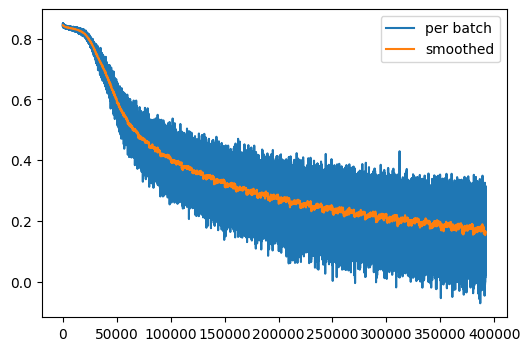

In [ ]:
warnings.filterwarnings("ignore", message="Corrupt EXIF data.  Expecting to read .* bytes but only got .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Metadata Warning, tag .* had too many entries: .* expected .*", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")

mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
valid_acc_a = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(torch.float)
        x = x/255
        x = x-0.5
        x = x.to(device)
        with torch.no_grad():
            x = codec.wavelet_analysis(x,codec.J)
            x = codec.encoder[:2](x)
            
        # forward
        logits = model(x)
        loss = nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    valid_acc_a.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    
    data_loader_valid2 = torch.utils.data.DataLoader(
        dataset_valid2,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )

    # standard validation set
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(torch.long).to(device)
        x = x.to(torch.float)
        x = x / 255
        x = x - 0.5
        x = x.to(device)
        with torch.no_grad():
            x = codec.wavelet_analysis(x, codec.J)
            x = codec.encoder[:2](x)
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    # adversarial validation set
    pb_valid2 = progress_bar(data_loader_valid2, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid2):
        y = y.to(torch.long).to(device)
        x = x.to(torch.float)
        x = x / 255
        x = x - 0.5
        x = x.to(device)
        with torch.no_grad():
            x = codec.wavelet_analysis(x, codec.J)
            x = codec.encoder[:2](x)
            logits = model(x)
        valid_acc_a[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc_a[i_epoch] /= len(dataset_valid2)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}, valid_acc_a {valid_acc_a[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'valid_acc_a': valid_acc_a,
        'config': config
    }, f"log_{device}.pth")

In [9]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [10]:
torch.save({
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'smoothed_y': smoothed_y,
    'valid_acc': valid_acc,
    'valid_acc_a': valid_acc_a,
    'config': config
}, f"../../hf/LCCL/classification_walloc_J3_27c_nf4.pth")

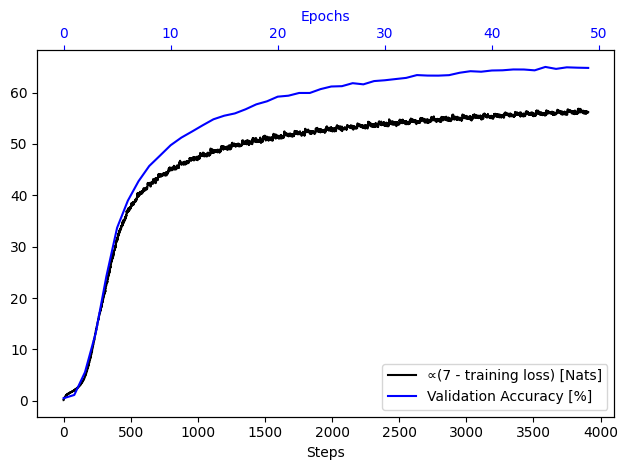

In [11]:
fn_train_loss = 10 * (7 - smoothed_y)
valid_acc_pct = 100*torch.tensor(valid_acc)
fig, ax1 = plt.subplots()
line1, = ax1.plot(fn_train_loss, label='Scaled (7 - Smoothed Y)', color='black')
ax1.set_xlabel('Steps')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')
ax2 = ax1.twiny()
line2, = ax2.plot(valid_acc_pct, label='Validation Accuracy', color='blue')
ax2.set_xlabel('Epochs', color='blue')  # Label for the top x-axis
ax2.tick_params(axis='x', colors='blue')
ax2.tick_params(axis='y', colors='blue')
ax1.legend(handles=[line1, line2], labels=['∝(7 - training loss) [Nats]', 'Validation Accuracy [%]'], loc='lower right')
fig.tight_layout()
plt.show()

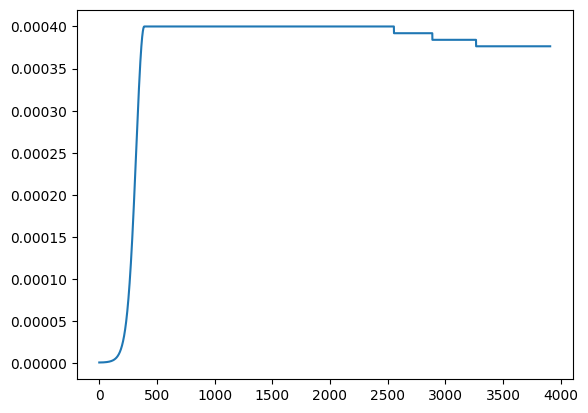

In [12]:
plt.plot(learning_rates)